In [1]:
### Importing public functions
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress, product
from array import array
import datetime as dt
import time


import pandas as pd
import numpy as np

import sklearn as sk

import scipy
from scipy.ndimage import uniform_filter1d

import matplotlib.pyplot as plt

# import seaborn as sns

from scipy import signal

# import ghostipy as gsp
# from pacpy.pac import plv

from scipy import fftpack, stats
# #mne
# import mne_bids
# import mne


In [2]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [3]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')


In [9]:
os.chdir(codepath)

# own functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_features.feats_helper_funcs as ftHelpers
import lfpecog_preproc.preproc_import_scores_annotations as importClin

import lfpecog_features.moveDetection_preprocess as movePrep
import lfpecog_features.moveDetection_run as run_tap_detect
import lfpecog_features.moveDetection_pausedTapFinder as findTap

import lfpecog_plotting.expl_plotting as explorPlot
import lfpecog_plotting.plotHelpers as plotHelp

import lfpecog_features.feats_spectral_features as specFts
# import lfpecog_features.feats_spectral_helpers as specHelpers
# import lfpecog_features.feats_main as ftsMain
# import lfpecog_features.feats_ftsExtr_Classes as ftClasses

import lfpecog_features.bursts_funcs as burst_funcs
import lfpecog_features.bursts_main as burst_main


In [11]:
os.chdir(codepath)

import utils.utils_windowing as utils_win
import utils.utils_fileManagement as fileMng

import lfpecog_plotting.plotFtsSegments as plotFtsSegm
import lfpecog_features.featsExtract_perSegment as getFtsSegm

import lfpecog_plotting.plotCreate_freqBandPowers as bandPowers


In [12]:
print('Python (sys):', sys.version_info)
print('NumPy:', np.__version__)
print('pandas:', pd.__version__)
print('SciPy:', scipy.__version__)
### Sept 2022
# Python (sys): sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
# NumPy: 1.20.3
# pandas: 1.3.4
# SciPy: 1.7.1

Python (sys): sys.version_info(major=3, minor=9, micro=0, releaselevel='final', serial=0)
NumPy: 1.23.3
pandas: 1.4.4
SciPy: 1.9.3


### 0. Creation of multi-modal DataFrames per Subject (if not done yet!)


If merged-dataframes per Subject don't exist yet: create dataframes via run_mergeDataClass

- set working directoy to /.../repo_folder/code

- run: `python -m lfpecog_features.run_mergeDataClass "012" "v3.0" (opt: "no_acc" "no_save")`


### 1. Patient-Run Definition and Processed Data Loading

#### Import priorly created full merged subject-DataFrames with raw ephys-data, tasks, and ACC-states

In [75]:
importlib.reload(read_data)

sub_dfs = read_data.main_loadMergedSubDfs(
    list_of_subs = [
        '012',
    ],
    tasks = ['rest'],
    data_version='v3.0',
    float_convert=False,
)
#TODO: CHECK WHY FLOAT CONVERTION IS MEGA SLOW!!

start loading rest DataFrames
	loading Sub 012 (rest)
c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\merged_sub_dfs\v3.0\012_mergedDf_
load data
load indices
load col names
resulting DF has shape (6758400, 39), and columns: Index(['dopa_time', 'ECOG_R_01_02', 'ECOG_R_02_03', 'ECOG_R_03_04',
       'ECOG_R_04_05', 'task', 'LFP_L_02_03', 'LFP_L_03_04', 'LFP_L_04_02',
       'LFP_L_02_05', 'LFP_L_03_06', 'LFP_L_04_07', 'LFP_L_05_06',
       'LFP_L_06_07', 'LFP_L_07_05', 'LFP_L_05_08', 'LFP_L_06_08',
       'LFP_L_07_08', 'LFP_R_01_02', 'LFP_R_01_03', 'LFP_R_01_04',
       'LFP_R_02_03', 'LFP_R_03_04', 'LFP_R_04_02', 'LFP_R_02_05',
       'LFP_R_03_06', 'LFP_R_04_07', 'LFP_R_05_06', 'LFP_R_06_07',
       'LFP_R_07_05', 'LFP_R_05_08', 'LFP_R_06_08', 'LFP_R_07_08',
       'LFP_R_08_01', 'left_tap', 'right_tap', 'left_move', 'right_move',
       'no_move'],
      dtype='object')
correct npy floats
consider ECOG_R_01_02
consider ECOG_R_02_03
consider ECOG_R_03_04


KeyboardInterrupt: 

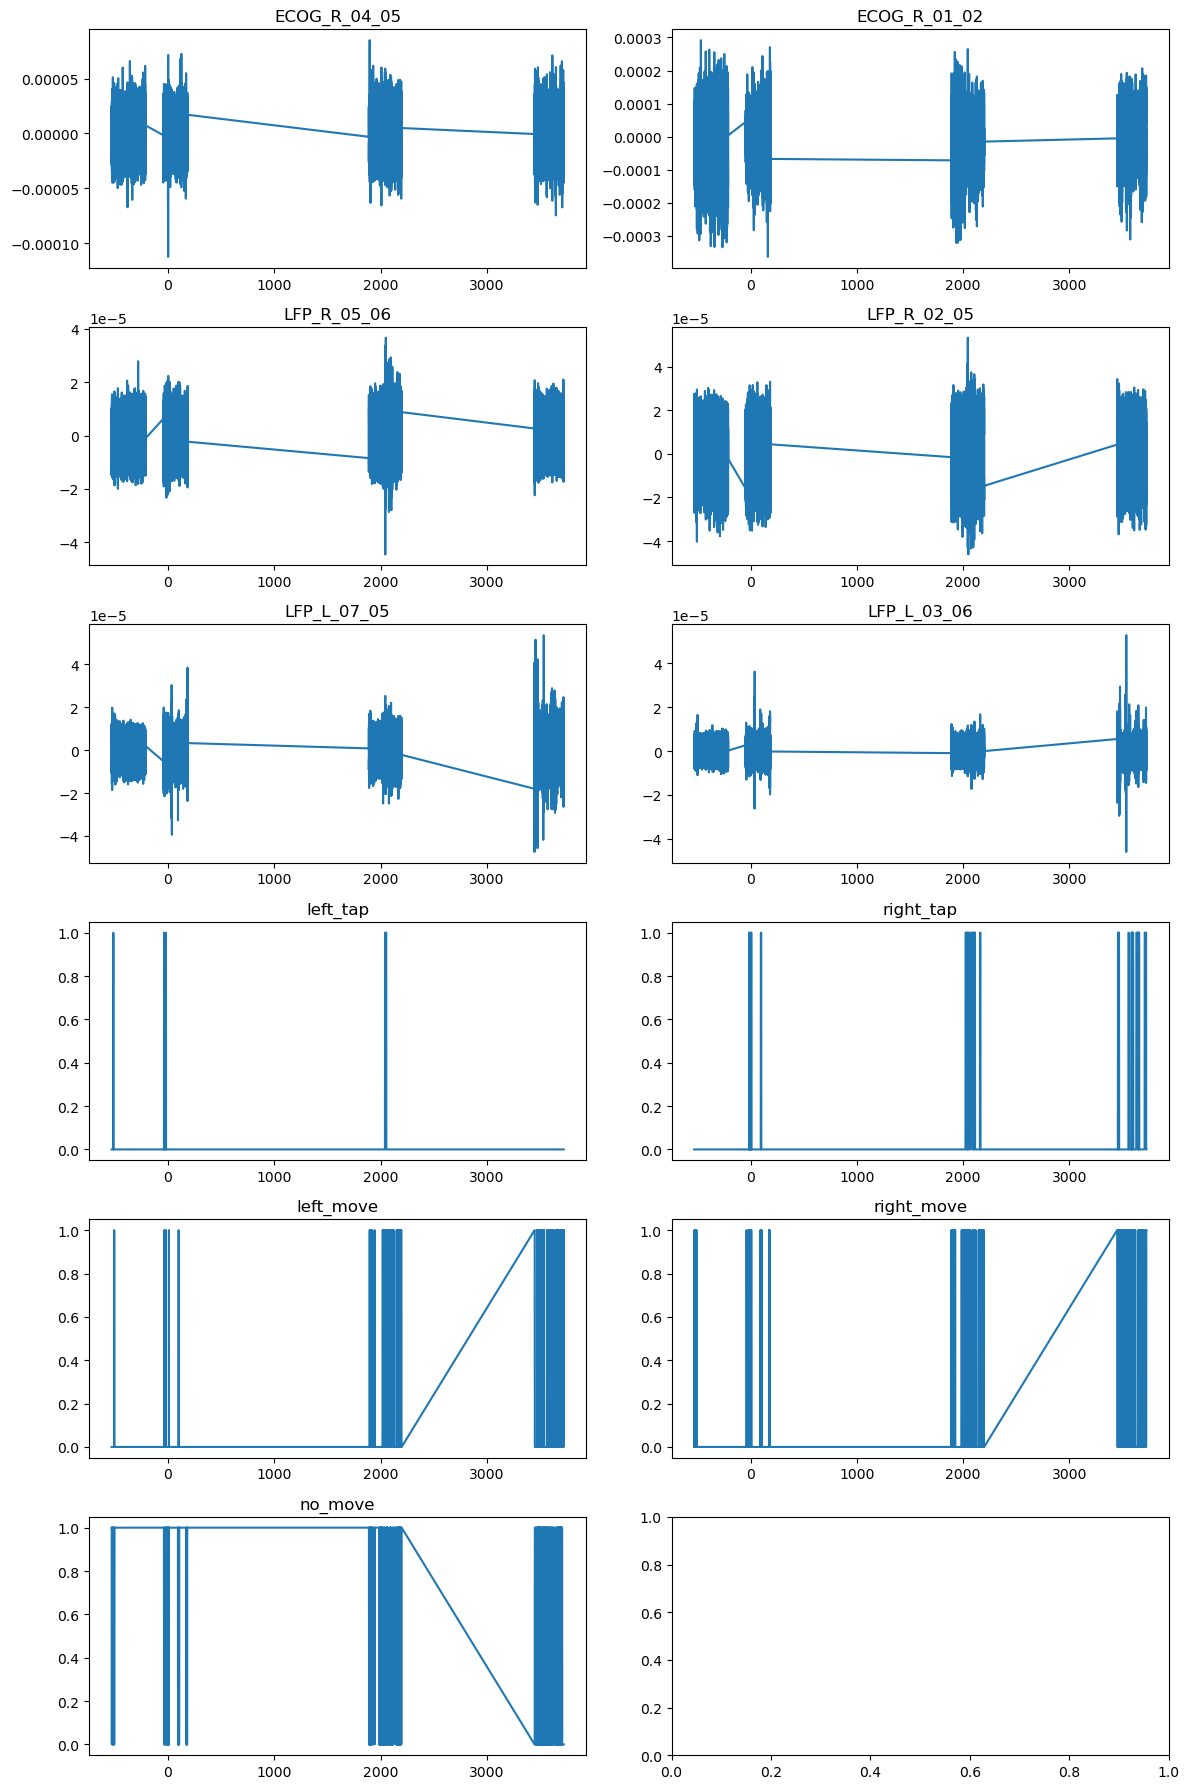

In [66]:
cols = [
    'ECOG_R_04_05', 'ECOG_R_01_02',
    'LFP_R_05_06', 'LFP_R_02_05',
    'LFP_L_07_05', 'LFP_L_03_06',
     'left_tap', 'right_tap', 'left_move',
    'right_move', 'no_move'
]
fig, axes = plt.subplots(len(cols) // 2 + 1, 2, figsize=(12, 18))
axes=axes.flatten()

for c, col in enumerate(cols):
    axes[c].plot(sub_dfs.rest.sub012['dopa_time'], sub_dfs.rest.sub012[col])
    axes[c].set_title(col)

plt.tight_layout()
plt.show()

#### Plot percentage of movement in ACC

In [74]:
importlib.reload(explorPlot)
explorPlot.plot_act_per_window(sub_dfs, winlength=60,)

#### 1b) Import processed dataclass per subject, optionally merge ACC-data into EPHYS-df

In [ ]:
# # Import subjectData Classes with alligned preprocessed Data
# importlib.reload(read_data)
# importlib.reload(add_moveStates)
# importlib.reload(findTap)

# incl_accStates = True

# subData = {}

# for sub in ['012', '014']:

#     print(f'start {sub}')
#     # if sub == '008': continue

#     subData[sub] = read_data.subjectData(
#         sub=sub,
#         data_version='v2.3',
#         project_path=projectpath,
#     )

#     if incl_accStates:
        
#         accStates = run_tap_detect.runTapDetection(subData[sub])

#         for group in subData[sub].dtypes:

#             if 'lfp' or 'ecog' in group:

#                 print(f'adding acc-states for {sub}: {group}')
#                 newdf = add_moveStates.add_detected_acc_states(
#                     df=getattr(subData[sub], group).data,
#                     detectedMoves=accStates,
#                 )
#                 getattr(subData[sub], group).data = newdf

#### 1c) Create and Store merged-dfs if not created already


Combines all pre-processed ephys and acc-data of all runs and
creates on large dataframe with all contiuous data, relative
to dopamine-intake time


In [151]:
importlib.reload(read_data)

save_dfs = True

mergedfs = {}

for sub in subData.keys():

    if sub in ['008', '013']: continue
    
    # print(f'merging data for: subject {sub}')
    # mergedfs[sub] = read_data.merge_ephys_sources(subData[sub])

    if save_dfs:
        print(f'saving data for subject {sub}')
        pathbase = os.path.join(
            projectpath, 'data',
            'preprocessed_data',
            'merged_sub_dfs',
            f'{sub}_mergeDf_'
        )
        # save data as npy array
        np.save(
            pathbase + 'data',
            mergedfs[sub].values,
        )
        # save index as npy array
        np.save(
            pathbase + 'timeIndex',
            mergedfs[sub].index.values
        )
        # save column names as csv
        with open(
            pathbase + 'columnNames.csv', 'w'
        ) as csvfile:

            write = csv.writer(csvfile)
            write.writerow(
                list(mergedfs[sub].keys())
            )
            csvfile.close()
        
        print(f'\n\tmerged DataFrame subject {sub} is stored\n')


merging data for: subject 012
saving data for subject 012

	merged DataFrame subject 012 is stored

merging data for: subject 014
saving data for subject 014

	merged DataFrame subject 014 is stored



#### 1d) Import clinical scores

In [9]:
# Develop clinical scores import
# TODO: merge into subjectData Classes df-rows
# TODO: tap-timings 94-columns), movement-timings (1-col), AIMS and CDRS classes
importlib.reload(importClin)

scores12, dopaTaps, _ = importClin.run_import_clinInfo(sub='012')

In [10]:
scores12

,dopa_time,AIMS_facial_oral,AIMS_upper_extr,AIMS_lower_extr,AIMS_trunk,AIMS_total,CDRS_face,CDRS_neck,CDRS_trunk,CDRS_upper_right,CDRS_upper_left,CDRS_lower_right,CDRS_lower_left,CDRS_total_right,CDRS_total_left,CDRS_total
0,0,0.0,2.0,2.0,1.0,5.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,4.0,2.0,7.0
1,10,0.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,4.0,2.0,7.0
2,20,1.0,3.0,3.0,3.0,10.0,1.0,2.0,3.0,4.0,2.0,4.0,2.0,8.0,4.0,18.0
3,30,1.0,3.0,4.0,2.0,10.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,8.0,6.0,19.0
4,40,1.0,3.0,4.0,2.0,10.0,0.0,1.0,2.0,3.0,2.0,4.0,2.0,7.0,4.0,14.0
5,50,1.0,3.0,4.0,2.0,10.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,7.0,5.0,17.0
6,60,1.0,3.0,4.0,2.0,10.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,7.0,6.0,17.0
7,70,1.0,3.0,4.0,2.0,10.0,1.0,1.0,2.0,2.0,2.0,4.0,4.0,6.0,6.0,16.0


### 2) Develop and Visualise Movement State Detection


#### Run single Acc-State Detections


In [256]:
importlib.reload(run_tap_detect)
importlib.reload(movePrep)
importlib.reload(findTap)

taplists = {}
for sub in ['012',  '014']:  # '008', '013',
    print(sub)
    taplists[sub] = run_tap_detect.runTapDetection(subData[sub])

012
start movement detection sub 012 left side
start movement detection sub 012 right side
TAP: [682986, 685251, 685299, nan]
TAP: [682986, 686539, 686600, nan]
TAP: [409461, 416003, 416028, nan]
014
start movement detection sub 014 left side
start movement detection sub 014 right side


#### Visualise Performance of Tap/Move-detection

In [336]:

fonts=20

for sub in list(subData.keys()):

    for x0, x1 in zip(
        # [9, 42],
        # [10, 43]
        [5, 37,],
        [15, 42]
    ):

        fig, axes = plt.subplots(2, 1, figsize=(16, 8))

        for s, side in enumerate(['left', 'right']):

            acc_df = getattr(subData[sub], f'acc_{side}').data  # per side
            fs = getattr(subData[sub], f'acc_{side}').fs

            ax = movePrep.find_main_axis(
                acc_df.iloc[:, 1:4].values
            )
            svm = movePrep.signalvectormagn(
                acc_df.iloc[:, 1:4].values
            )

            axes[s].plot(
                acc_df['dopa_time'] / 60,
                acc_df.iloc[:, ax + 1],
                alpha=.4, label='uni-axis'
            )
            axes[s].plot(
                acc_df['dopa_time'] / 60,
                movePrep.signalvectormagn(
                    acc_df.iloc[:, 1:4].values
                ), alpha=.4, label='svm', c='r', ls='dotted',
            )

            axes[s].scatter(
                np.array([l[0] for l in taplists2[sub][f'{side}_tap_t']]) / 60,
                [.65e-6] * len(taplists2[sub][f'{side}_tap_t']),
                s=50, color='g', label='tap-start',
            )
            axes[s].scatter(
                np.array([l[-1] for l in taplists2[sub][f'{side}_tap_t']]) / 60,
                [.6e-6] * len(taplists2[sub][f'{side}_tap_t']),
                s=50, color='r', label='tap-end'
            )
            axes[s].scatter(
                np.array([m[0] for m in taplists2[sub][f'{side}_move_t']]) / 60,
                [.55e-6] * len(taplists2[sub][f'{side}_move_t']),
                s=50, color='orange', label='move-start'
            )
            axes[s].scatter(
                np.array([m[1] for m in taplists2[sub][f'{side}_move_t']]) / 60,
                [.5e-6] * len(taplists2[sub][f'{side}_move_t']),
                s=50, color='purple', label='move-end'
            )

            axes[s].set_xlim(x0, x1)
            axes[s].set_ylim(-1e-6, 1e-6)
            axes[s].set_ylabel(
                f'Acceleration\n{side.upper()}'
                    '\n(g, m/s/s)',
                size=fonts
            )
            axes[s].tick_params(labelsize=fonts - 4)

        axes[s].set_xlabel('Time (minutes to L-Dopa intake)', size=fonts)


        plt.suptitle(
            f'Subject {sub} -  bilateral '
            'Movement detection',
            x=.1, y=.96, ha='left',
            size=fonts+4
        )
        # remove duplicate legend labels
        handles, labels = plotHelp.remove_duplicate_legend(
            plt.gca().get_legend_handles_labels()
        )

        fig.legend(
            handles, labels,
            frameon=False, fontsize=fonts - 4, ncol=3,
            loc='center left', bbox_to_anchor = [.55, .95])
        
        plt.tight_layout()

        # plt.savefig(os.path.join(
        #     fig_dir, 'tapping_detection',
        #     f'sub{sub}_moveDetect_newBorders_min{x0}_{x1}'
        # ), dpi=150, facecolor='w',)

        plt.close()

## Explore Rest-Data


- Rest DataFrames per subject can be defined in part 1A.
- TODO: selection on ACC-label
- TODO expand Feature Extraction:
    - coherence functionality
    - PAC

### Feature Extract

#### a) SPECTRAL POWERS

In [73]:
importlib.reload(importClin)
lid_timings = importClin.get_seconds_of_LID_start()
sub_scores, dopaTaps, _ = importClin.run_import_clinInfo(sub='012')


####   Create PSD-Classes and/or Plot resulting Time-Freq-Plots

In [782]:
sub_dfs.rest

,dopa_time,LFP_L_1_2,LFP_L_2_3,task,left_tap,right_tap,left_move,right_move,no_move,ECOG_R_01,ECOG_R_02,ECOG_R_03,ECOG_R_04,ECOG_R_05,ECOG_R_06,LFP_R_0_1,LFP_R_1_2,LFP_R_2_3
-536.000000,-536.000000,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,-0.000059,0.000059,NaN,NaN,NaN,NaN,0.000049,0.000026,-0.00009
-535.999375,-535.999375,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,0.000056,-0.000056,NaN,NaN,NaN,NaN,-0.000049,-0.000023,0.000086
-535.998750,-535.998750,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,-0.000059,0.000059,NaN,NaN,NaN,NaN,0.000047,0.000025,-0.000089
-535.998125,-535.998125,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,0.00005,-0.00005,NaN,NaN,NaN,NaN,-0.000047,-0.000022,0.000079
-535.997500,-535.997500,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,-0.000062,0.000062,NaN,NaN,NaN,NaN,0.000044,0.000024,-0.000087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729.996875,3729.996875,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3729.997500,3729.997500,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3729.998125,3729.998125,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3729.998750,3729.998750,NaN,NaN,rest,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [784]:
### TODO: MAKE PART OF CURR CONNECT FT RUN FUCTION


importlib.reload(ftHelpers)
importlib.reload(plotFtsSegm)
importlib.reload(getFtsSegm)
# psdClass made with rest_dfs

psdClass = plotFtsSegm.run_segmentFts(

    sub_dfs = sub_dfs.rest,
    fs = 1600,
    subs_incl = ['008', ],#'012', '013', '014'],  # 
    ephysSources_incl = ['LFP_L', 'LFP_R', 'ECOG'],
    # winLen_sec = 120,  # 180 is default
    # segLen_sec = .5,  # .5 is default
    # part_segOverlap = 0.5,  # 0 is default
    fig_dir = fig_dir,
    return_class=True,
    to_save_timeFreqPlot=False,
    to_show_timeFreqPlot=False,
    plot_norm_method='relative_psd'
)

start ft extraction LFP_L (008)
start ft extraction LFP_R (008)
start ft extraction ECOG (008)


In [172]:

importlib.reload(ftHelpers)
importlib.reload(plotFtsSegm)
importlib.reload(getFtsSegm)

# ONLY Plot TimeFreq Plots
for sub in psdClass.keys():

    if sub != '013': continue

    for ephyGr in ['ECOG',]:   #'LFP_L', 'LFP_R', 'ECOG']:

        plotFtsSegm.plot_timeFreqSeg_perGroup(
            psdClass[sub][ephyGr],
            fig_dir,
            winLen_sec=180,
            segLen_sec=.5,
            norm_method='relativePsx',
            LID_timings=lid_timings[sub],
            to_save=True,
            to_show=False,
        )

#### * Plot specific spectral Bandwidth-Powers over Time

In [175]:
importlib.reload(bandPowers)

featClassSel = nomovePsdClasses

for sub in featClassSel.keys():

    if sub != '013': continue
    
    for ephyGroup in ['LFP_R', 'LFP_L', 'ECOG']:

        if ephyGroup != 'ECOG': continue

        cols = vars(featClassSel[sub][ephyGroup]).keys()

        ephyCols = [getattr(featClassSel[sub][ephyGroup], c) for c in cols if ephyGroup in c]
        
        print(f'plotting {sub}, {ephyGroup}')

            # print(col.upper())
        bandPowers.plot_bandPower_colormap(
            inputChannels=ephyCols,
            ft_type = 'Spectral Power',
            to_Zscore=True,
            to_Smooth=True,
            smoothWin_sec=10,
            to_save=True,
            to_show=False,
            fig_dir=fig_dir,
            sub=sub,
            fig_name=f'{sub}_restNoMove_freqBands_{ephyGroup}',
        )



plotting 013, ECOG


#### b) SPECTRAL BURST-ANALYSIS

### TODO: take selected windows within spectral PSD function and add possibility of adding burst-analysis in function; also create inlude in mainfunction the functionality to only do bursts without PSDs

In [41]:
importlib.reload(burst_main)
importlib.reload(burst_funcs)

# restBursts, burstTimes, burstTasks = {}, {}, {}

for sub in rest_dfs.keys():

    print(sub)
    if sub in ['008', '012', '013']: continue
    
    ephysCols = [c for c in rest_dfs[sub].keys() if c[:2] in ['EC', 'LF']]


    # restBursts[sub], burstTimes[sub], burstTasks[sub], ftNames = burst_main.get_bursts_main(
    #     rest_dfs[sub],
    #     ephysCols,
    #     1600,
    #     winLen_minutes = 3,
    #     winOverlap_part = .5,
    #     segLen_sec = .5,
    #     minWin_available = .5,  # skip window if less than this part of potential window is available
    #     burstCutoffPerc = 75,
    #     min_shortBurst_sec = 0.1,
    #     min_longBurst_sec = 0.2,  # consider more detailed distribution
    # )

008
012
013
014


In [ ]:
### Store burst-dynamics
sub = '014'
np.save(
    os.path.join(
        projectpath, 'data',
        'analysis_derivatives',
        f'sub-{sub}',
        f'{sub}_restBursts'
    ),
    restBursts[sub],
    allow_pickle=True
)

# # store corr burst-times
np.save(
    os.path.join(
        projectpath, 'data',
        'analysis_derivatives',
        f'sub-{sub}',
        f'{sub}_restBursts_times'
    ),
    burstTimes[sub],
    allow_pickle=True
)
# store corr burst-tasks
np.save(
    os.path.join(
        projectpath, 'data',
        'analysis_derivatives',
        f'sub-{sub}',
        f'{sub}_restBursts_tasks'
    ),
    burstTasks[sub],
    allow_pickle=True
)
# # save ftNames list as csv
with open(
    os.path.join(
        projectpath, 'data',
        'analysis_derivatives',
        f'sub-{sub}',
        f'{sub}_restBursts_ftNames.csv'
    ), 'w'
) as csvfile:

    write = csv.writer(csvfile)
    write.writerow(
        ftNames
    )
    csvfile.close()

In [ ]:
# Import burst-features (nested-dict stored as .npy)
# TODO: include import of bursts times/tasks/ftnames
# TODO: create function
loadBursts = {}

for sub in []:
    
    loadBursts[sub] = np.load(
        os.path.join(
            projectpath, 'data',
            'analysis_derivatives',
            f'sub-{sub}',
            f'{sub}_restBursts.npy'
        ),
        allow_pickle=True
    )

#### c) COHERENCES



In [644]:
import lfpecog_features.featsConnectExtract_perSegment as extractConnFts

In [1077]:
importlib.reload(extractConnFts)
importlib.reload(utils_win)
importlib.reload(specFts)

# epochedFts = {}

nomoveEpochFts = {}

for sub in ['008', '012', '013', '014']:

    print(f'start sub {sub}')

    nomoveEpochFts[sub] = extractConnFts.run_segmConnectFts(
        sub=sub,
        sub_df=getattr(sub_dfs.rest, f'sub{sub}'),
        fs=1600,
        winLen_sec=60,
        part_winOverlap=.5,
        segLen_sec=.5,
        movement_part_acceptance=.25,
    )


start sub 008
got windows
got epoched data
Coherence fts to include: ['COH', 'ICOH', 'absICOH', 'sqCOH']
	starting feature extraction: SEED: LFP_L_0_1 x TARGET: ECOG_L_01
	starting feature extraction: SEED: LFP_L_0_1 x TARGET: ECOG_L_02
	starting feature extraction: SEED: LFP_L_0_1 x TARGET: ECOG_L_03
	starting feature extraction: SEED: LFP_L_0_1 x TARGET: ECOG_L_04
	starting feature extraction: SEED: LFP_L_0_1 x TARGET: ECOG_L_05
	starting feature extraction: SEED: LFP_L_0_1 x TARGET: ECOG_L_06
	starting feature extraction: SEED: LFP_L_1_2 x TARGET: ECOG_L_01
	starting feature extraction: SEED: LFP_L_1_2 x TARGET: ECOG_L_02
	starting feature extraction: SEED: LFP_L_1_2 x TARGET: ECOG_L_03
	starting feature extraction: SEED: LFP_L_1_2 x TARGET: ECOG_L_04
	starting feature extraction: SEED: LFP_L_1_2 x TARGET: ECOG_L_05
	starting feature extraction: SEED: LFP_L_1_2 x TARGET: ECOG_L_06
	starting feature extraction: SEED: LFP_L_2_3 x TARGET: ECOG_L_01
	starting feature extraction: SEED: L

In [1025]:
print(vars(test).keys())
print(vars(test.features.LFP_L_0_1_ECOG_L_01).keys())
print(vars(test.features).keys())    #
print(vars(test.features.epochChannels.windows).keys())    #

dict_keys(['sub', 'sub_df', 'fs', 'winLen_sec', 'part_winOverlap', 'segLen_sec', 'part_segmOverlap', 'channels_incl', 'channels_excl', 'channels', 'allCombis', 'features'])
dict_keys(['channelName', 'epoch_times', 'ft_lists', 'freqs', 'winStartTimes', 'COH', 'ICOH', 'absICOH', 'sqCOH'])
dict_keys(['epochChannels', 'fs', 'allCombis', 'fts_to_extract', 'LFP_L_0_1_ECOG_L_01', 'LFP_L_0_1_ECOG_L_02', 'LFP_L_0_1_ECOG_L_03', 'LFP_L_0_1_ECOG_L_04', 'LFP_L_0_1_ECOG_L_05', 'LFP_L_0_1_ECOG_L_06', 'LFP_L_1_2_ECOG_L_01', 'LFP_L_1_2_ECOG_L_02', 'LFP_L_1_2_ECOG_L_03', 'LFP_L_1_2_ECOG_L_04', 'LFP_L_1_2_ECOG_L_05', 'LFP_L_1_2_ECOG_L_06', 'LFP_L_2_3_ECOG_L_01', 'LFP_L_2_3_ECOG_L_02', 'LFP_L_2_3_ECOG_L_03', 'LFP_L_2_3_ECOG_L_04', 'LFP_L_2_3_ECOG_L_05', 'LFP_L_2_3_ECOG_L_06', 'LFP_L_3_4_ECOG_L_01', 'LFP_L_3_4_ECOG_L_02', 'LFP_L_3_4_ECOG_L_03', 'LFP_L_3_4_ECOG_L_04', 'LFP_L_3_4_ECOG_L_05', 'LFP_L_3_4_ECOG_L_06'])
dict_keys(['data', 'keys', 'win_starttimes'])


#### BANDWIDTH RANGES PLOT FOR COHERENCES


In [1130]:
### BANDWIDTH RANGES PLOT FOR COHERENCES

importlib.reload(bandPowers)
# epochedFts  // nomoveEpochFts
for sub in nomoveEpochFts:
    print(f'start sub {sub}')
    if sub != '012': continue
    # elif sub == '014': continue

    subftclass = nomoveEpochFts[sub]

    # find unique STN contacts in connectivity features
    stnContacts = np.unique(
        [subftclass.features.allCombis[i][0] for i
        in range(len(subftclass.features.allCombis))]
    )

    for stnCh in stnContacts:
        print(f'start {stnCh}')

        cols = vars(subftclass.features).keys()
        ch_cols = [c for c in cols if stnCh in c]
        if len(ch_cols) == 0: continue

        chClasses = [getattr(subftclass.features, c) for c in ch_cols]

        bandPowers.plot_bandPower_colormap(
            inputChannels=chClasses,
            ft_type = 'abs-Imag-Coherence',  # 'Squared-Coherence' // 'abs-Imag-Coherence'
            to_Zscore=False,
            to_Smooth=False,
            smoothWin_sec=30,
            to_include_clinScores=True,
            to_save=True,
            to_show=False,
            fig_dir=fig_dir,
            sub=sub,
            fig_name=f'{sub}_rest_NoMove_CDRS_1minEpochs_freqBand_absICOH_{stnCh}',
        )

start sub 008
start sub 012
start LFP_R_0_1
start LFP_R_1_2
start LFP_R_2_3
start sub 013
start sub 014


#### TIME FREQUENCY PLOT FOR COHERENCES


In [1131]:
import lfpecog_plotting.plot_timeFreq_Connectivity as timeFreq_Coh


In [1177]:
### TIME FREQUENCY PLOT FOR COHERENCES

importlib.reload(timeFreq_Coh)

# epochedFts  // nomoveEpochFts
for sub in epochedFts:
    print(f'start sub {sub}')
    # if sub != '012': continue
    # elif sub == '014': continue

    subftclass = epochedFts[sub]

    # find unique STN contacts in connectivity features
    stnContacts = np.unique(
        [subftclass.features.allCombis[i][0] for i
        in range(len(subftclass.features.allCombis))]
    )
    
    for stnCh in stnContacts:
        print(f'start {stnCh}')

        cols = vars(subftclass.features).keys()
        ch_cols = [c for c in cols if stnCh in c]
        if len(ch_cols) == 0: continue

        chClasses = [getattr(subftclass.features, c) for c in ch_cols]

        timeFreq_Coh.plot_timeFreq_Coherence(
            inputChannels=chClasses,
            ft_type = 'abs-Imag-Coherence',  # 'Squared-Coherence' // 'abs-Imag-Coherence'
            to_include_clinScores=True,
            to_save=True,
            to_show=False,
            fig_dir=fig_dir,
            sub=sub,
            fig_name=f'{sub}_rest_1minEpochs_timeFreq_absICOH_{stnCh}',
        )

start sub 008
start LFP_L_0_1
start LFP_L_1_2
start LFP_L_2_3
start LFP_L_3_4
start sub 012
start LFP_R_0_1
start LFP_R_1_2
start LFP_R_2_3
start sub 013
start LFP_R_0_1
start LFP_R_1_2
start LFP_R_2_3
start sub 014
start LFP_R_0_1
start LFP_R_1_2
start LFP_R_2_3


#### b4) rest-features: PAC


PM see Swann 2016 for inspiration how to plot phase vs amplitudes

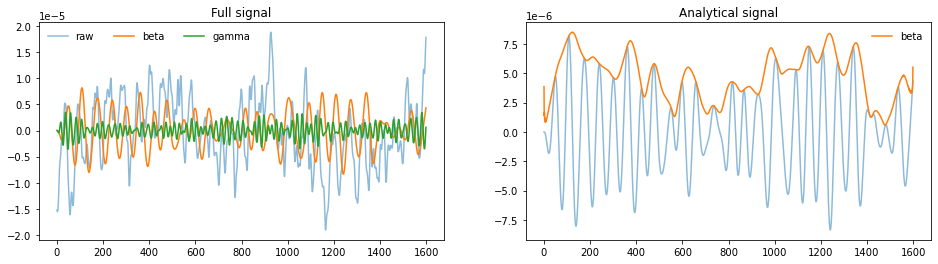

In [753]:
# Plot original signal and Hilbert-envelop (py-function vs rectified (abs))
fs = shortFts['012'].lfp_right.LFP_R_0_1.fs

rawsig = shortFts['012'].lfp_right.LFP_R_0_1.winData[4000, :]
betasig = specFts.bandpass(rawsig, [12, 30], fs)
gammasig = specFts.bandpass(rawsig, [60, 90], fs)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(rawsig, alpha=.5, label='raw')
axes[0].plot(betasig, label='beta')
axes[0].plot(gammasig, label='gamma')

axes[0].legend(frameon=False, ncol=3)
axes[0].set_title('Full signal')

# Rectified signal and Hilbert envelop
# anal_sig_func = abs
# axes[1].plot(rawsig, alpha=.5,)
axes[1].plot(betasig, alpha=.5,)
# axes[1].plot(gammasig, alpha=.5,)
# axes[1].plot(abs(signal.hilbert(rawsig)), alpha=.5, label='raw')
axes[1].plot(abs(signal.hilbert(betasig)), label='beta')
# axes[1].plot(abs(signal.hilbert(gammasig)), label='gamma')

axes[1].legend(frameon=False, ncol=3)
axes[1].set_title('Analytical signal')



plt.show()

### VIsualisation Features

#### Manual Video-Movement Annotation

In [ ]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


In [ ]:
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
testannot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()
# testannot


#### Automated Acc-based Tap detection incl. plotting

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa35'
sides = ['left', 'right']
tap_fig_dir = os.path.join(projectpath, 'figures/tapping_detection')

In [ ]:
importlib.reload(tap_run)

restTest, tapTest, _ = tap_run.runTapDetection(
    task='paused', fs=SUB08.runs[run].acc_right_Fs,
    leftxyz=[accleft[run][0, :], accleft[run][1, :],
    accleft[run][2, :]], rightxyz=[accright[run][0, :],
    accright[run][1, :], accright[run][2, :]],
)



START left side
1.121970047728486e-07 17 17
logAND is TRUE from rest 366
start of TAP/MOV 1.3276377210030713e-07 366
after lowpeak(UP) coming back up 384
endUP 388
START DOWN MOVEMENT 464
Fastest DOWN MOVEMENT 475
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 1511
start of TAP/MOV 1.1851244079397509e-07 1511
after lowpeak(UP) coming back up 1526
endUP 1539
START DOWN MOVEMENT 1607
Fastest DOWN MOVEMENT 1614
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2500
start of TAP/MOV 1.303586646046799e-07 2500
after lowpeak(UP) coming back up 2515
endUP 2519
START DOWN MOVEMENT 2594
Fastest DOWN MOVEMENT 2604
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3499
start of TAP/MOV 1.3153520968013539e-07 3499
after lowpeak(UP) coming back up 3512
endUP 3518
START DOWN MOVEMENT 3601
Fastest DOWN MOVEMENT 3611
ended MOVE bcs next10 inactive
ended MOV

In [ ]:
### Main function to perform TapDetection functions
    ## make new main-function

importlib.reload(Tap2)

# accright, accleft = {}, {}
# restDict, tapDict, moveDict = {}, {}, {}

for run in SUB08.runs_incl[1:]:
    print(f'Start RUN: {run}')
    fs=SUB08.runs[run].acc_right_Fs
    accright[run] = SUB08.runs[run].acc_right_arr[1:, :]
    accleft[run] = SUB08.runs[run].acc_left_arr[1:, :]

    restDict[run], tapDict[run], moveDict[run] = runTapDetection(
        task='paused', fs=SUB08.runs[run].acc_right_Fs,
        leftxyz=[accleft[run][0, :], accleft[run][1, :],
        accleft[run][2, :]], rightxyz=[accright[run][0, :],
        accright[run][1, :], accright[run][2, :]],
    )


Start RUN: SelfpacedHandTapL_StimOffDopa60


START left side
1.012731518833157e-07 17 14
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 946
start of TAP/MOV 1.1483229646828269e-07 946
after lowpeak(UP) coming back up 1048
endUP 1055
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2131
start of TAP/MOV 1.2207354651560685e-07 2131
after lowpeak(UP) coming back up 2153
endUP 2157
START DOWN MOVEMENT 2229
Fastest DOWN MOVEMENT 2239
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3107
start of TAP/MOV 1.2677018217050875e-07 3107
after lowpeak(UP) coming back up 3122
endUP 3126
START DOWN MOVEMENT 3195
Fastest DOWN MOVEMENT 3202
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 4029
start of TAP/MOV 1.2250273844703196e-07 4029
after lowpeak(UP) coming back up 4045
endUP 4050
START DOWN MOVEMENT 4106
Fastest DOWN MOVEMENT 4117
ended MOVE bc

In [ ]:
### (function to be) get runstartTimes (include in RUN CLASS (real and dopa times))
deriv_dir = os.path.join(projectpath, 'data/analysis_derivatives')
runTimes = pd.read_excel(
    os.path.join(deriv_dir, f'sub-{sub}', f'sub{sub}_runsInfo.xlsx'))

runStartTimes = {}
for run in SUB08.runs_incl:
    for row in np.arange(runTimes.shape[0]):
        if run[-6:] in runTimes.iloc[row]['filename']:
            t = runTimes.iloc[row]['acq_time']
            runStartTimes[run] = pd.Timestamp(t)

In [ ]:
### Import and process video-annotated tap-times ###

## (function to be) Convert video-annotated tap-stamps
## into seconds after tmsi-recording

# import annotated taptimes (function to be?)
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
tapAnnot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()

ann_times = {}
tapsAnnot_in_runSecs = {}

for run in tapDict.keys():
    if 'Tap' not in run: continue

    # real-time timestamps of video-annotated taps
    dt_string = '%Y-%m-%d %H:%M:%S'
    t0 = tapAnnot[run]['starttime']
    try:
        t0 = dt.datetime.strptime(t0, dt_string)
    except ValueError:
        t0 = dt.datetime.strptime(t0, '%Y-%m-%d %H:%M')

    ann_times[run] = {}
    tapsAnnot_in_runSecs[run] = {}

    for side in sides:
        ann_times[run][side] = [t0 + dt.timedelta(
            seconds=t) for t in tapAnnot[run][side]]
    # minus video start-time -> time after video-start
        tapsAnnot_in_runSecs[run][side] = [
            (t - runStartTimes[run]).total_seconds(
            ) for t in ann_times[run][side]
        ]


In [ ]:
### TO DO:
# - WHY IS check_Polarity turning the signal falsely?
# - Why is tapdetection from TapDopa15 Right empty? 
    # plot incl peaks and thresholds etc

# - include plotting of OTHER MVOEMENTS
# - split py function for tapping in several py docs!!

Plot Figure for run SelfpacedHandTapL_StimOffDopa15


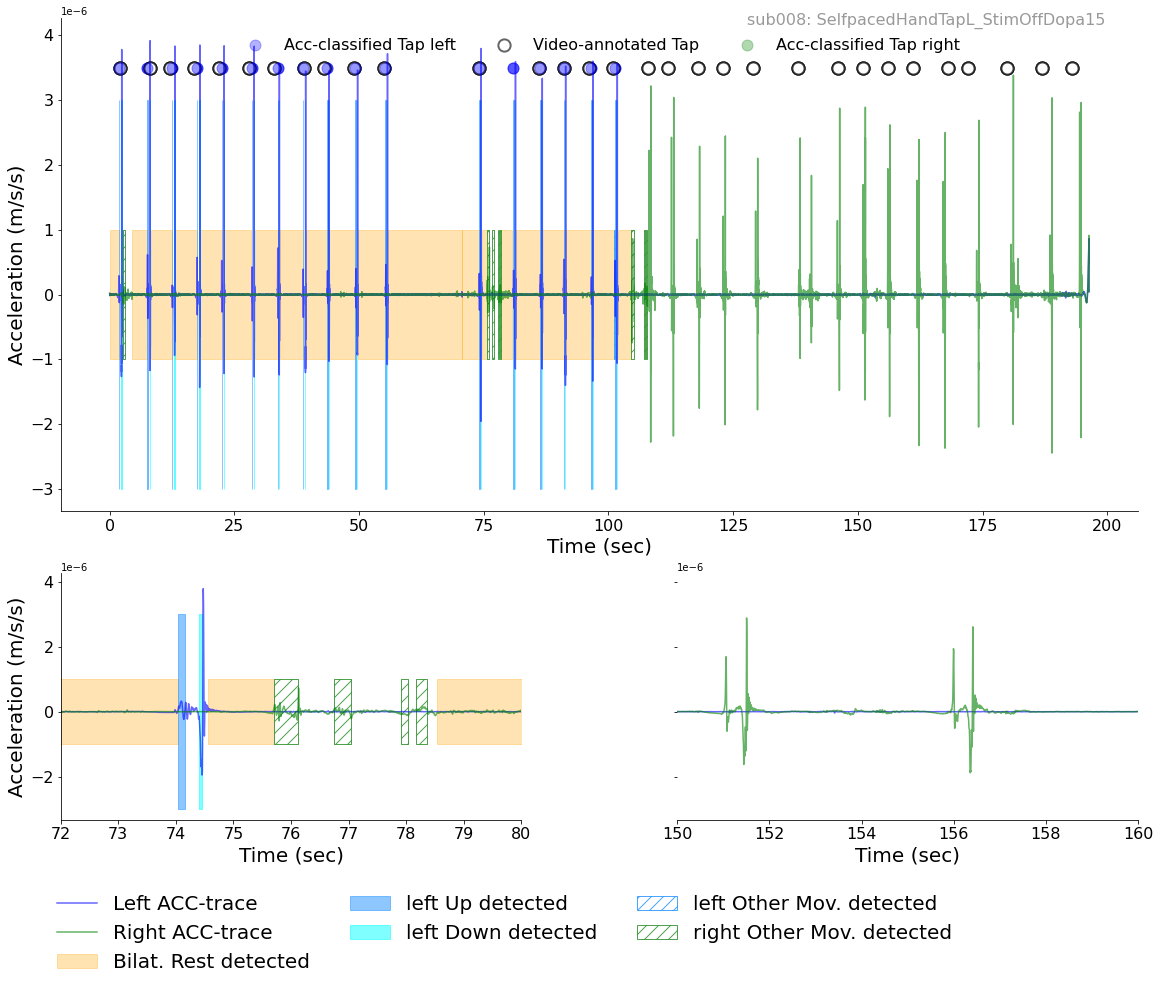

In [ ]:
### Create plotting functions for tapping

from matplotlib.gridspec import GridSpec

run = list(tapsAnnot_in_runSecs.keys())[2]

print(f'Plot Figure for run {run}')
# specify x-coordinates of zoomed-in subplots
ax1_x1, ax1_x2 = 72, 80
ax2_x1, ax2_x2 = 150, 160
plot_fname=f'TapDetect_08_{run}'
if ax1_x1: plot_fname += f'_zooms_{ax1_x1}_{ax2_x1}'
plot_fdir=tap_fig_dir

plot_params = {
        'left': {
            'color': 'b',
            'alpha': .6
        },
        'right': {
            'color': 'g',
            'alpha': .6
        },
        'rest': {
            'color': 'orange',
            'alpha': .3
        },
        'left_up': {
            'color': 'dodgerblue',
            'alpha': .5
        },
        'left_down': {
            'color': 'cyan',
            'alpha': .5
        },
        'left_other': {
            'facecolor': 'white',
            'edgecolor': 'dodgerblue',
            'alpha': .8,
            'hatch': '//'
        },
        'right_up': {
            'color': 'forestgreen',
            'alpha': .5
        },
        'right_down': {
            'color': 'lime',
            'alpha': .5
        },
        'right_other': {
            'facecolor': 'white',
            'edgecolor': 'forestgreen',
            'alpha': .8,
            'hatch': '//'
        }
    }

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(3, 9, figure=fig)

ax0 = fig.add_subplot(gs[:2, :])
ax1 = fig.add_subplot(gs[2, :4])
ax2 = fig.add_subplot(gs[2, 5:], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

for ax in [ax0, ax1, ax2]:
    # Plotting traces
    ax.plot(
        np.arange(0, accleft[run][1, :].shape[0]) / fs,
        accleft[run][1, :], **plot_params['left'],
        label='Left ACC-trace',
    )
    ax.plot(
        np.arange(0, accright[run][1, :].shape[0]) / fs,
        accright[run][1, :], **plot_params['right'],
        label='Right ACC-trace',
    )
    # Plot bilateral Rest-epochs
    for d in restDict[run]:
        ax.fill_betweenx(label='Bilat. Rest detected',
            y=[-1e-6, 1e-6], x1=restDict[run][d][0],
            x2=restDict[run][d][1],
            **plot_params['rest'],)

    # Plot Tap and other-movem. epochs
    for side in ['left', 'right']:
        ## plot Taps
        for t, tList in enumerate(tapDict[run][side]):
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[0], x2=tList[2],
                label=f'{side} Up detected',
                **plot_params[f'{side}_up'],
            )
            # ax.scatter(tList[1], )  # plot fastest point
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[3], x2=tList[4],
                label=f'{side} Down detected',
                **plot_params[f'{side}_down'],
            )
        
        ## Plot Other Movement's
        for t, tList in enumerate(moveDict[run][side]):
            ax.fill_betweenx(
                y=[-1e-6, 1e-6],
                x1=tList[0], x2=tList[1],
                label=f'{side} Other Mov. detected',
                **plot_params[f'{side}_other'],
            )
        
        ## Plot Accuracy circles based on video-annotations
        vid_circle_pos = tapsAnnot_in_runSecs[run][side]
        acc_circle_pos = [t[0] for t in tapDict[run][side]]
        ax0.scatter(
            vid_circle_pos, [3.5e-6] * len(vid_circle_pos),
            s=150, edgecolor='k', facecolor='w', lw=2,
            label='Video-annotated Tap', **plot_params['left'],
        )
        ax0.scatter(
            acc_circle_pos, [3.5e-6] * len(acc_circle_pos),
            s=120, color=plot_params[side]['color'], alpha=.3,
            label=f'Acc-classified Tap {side}'
        )
        tapAcc_handles, tapAcc_labels = ax0.get_legend_handles_labels()
        tapAcc_handles = tapAcc_handles[-3:]
        tapAcc_labels = tapAcc_labels[-3:]
        ax0.legend(tapAcc_handles, tapAcc_labels,
            fontsize=16, ncol=3, frameon=False,
            loc='upper center', bbox_to_anchor=(.5, .99))

        # plot findpeak dots to optimize algorithm
        # posPeaks = signal.find_peaks(
        #     accleft[run][1, :],
        #     height=np.max(accleft[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='k')
        # posPeaks = signal.find_peaks(
        #     accright[run][1, :],
        #     height=np.max(accright[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='gray')
        
        
    # make plots pretty
    ax.set_xlabel('Time (sec)', size=20)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # helping lines for alforithm finetuning
    # ax.axhline(np.median(spos), label='median')
    # ax.axhline(np.percentile(spos, 75), label='75-%', ls='dotted')
    # ax.axhline(-np.percentile(spos, 75), label='-75-%', color='red', ls='dotted')

# make plot pretty
for ax in [ax0, ax1]: ax.set_ylabel('Acceleration (m/s/s)', size=20)
ax2.spines['left'].set_visible(False)

# define zoomed subplots
ax1.set_xlim(ax1_x1, ax1_x2)
ax2.set_xlim(ax2_x1, ax2_x2)

# get rid off duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    fontsize=20, frameon=False, ncol=3,
    loc='upper left', bbox_to_anchor=(.03, -.01)
)
plt.suptitle(f'sub008: {run}', x=.8, y=.99,
    color='gray', alpha=.8, fontsize=16,)
# plt.tight_layout(pad=.1)

plt.savefig(os.path.join(plot_fdir, plot_fname),
    dpi=150, facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
### PLOTTING ###
## using xyz input and output-indices of pausedTap function
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(xEpoch, label='x', alpha=.5, c='blue')
ax.plot(yEpoch, label='y', alpha=.8, c='green')
ax.plot(zEpoch, label='z', alpha=.5, c='orange')
# plot vertical lines at tap-moments
for t, tap in enumerate(tapi):
    if t == 0:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
    else:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
peakcol = ['lightgreen', 'green', 'orange', 'r']
for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        yEpoch[peaks[0]],
        label=peaklabel[p],
        color=peakcol[p],
        s=50,
    )

for mov in movei:  # check saved otherMovements
    ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
    ax.axvline(mov[-1], color='gray', lw=1)

# ax.axhline(-.5e-7)
ax.axhline(posThr)
ax.axhline(0, c='gray', lw=.5,)
# determine what to show
ax.set_ylim(-2.5e-6, 2.5e-6)
# ax.set_xlim(istart, istop)
ax.set_xlim(0, 30000)
# ax.set_xticks(np.arange(18600, 20001, 200))
# ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)
xticks = np.arange(0, len(yEpoch), 6000)
xlabs = np.arange(0, len(yEpoch) / 12000, .5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
ax.set_xlabel('Time (minutes)', size=14)

ax.set_title(run)

# ax.legend(frameon=False, fontsize=14, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot Rest-moments
for idx in resti:
    ax.fill_betweenx(
        y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
        color='blue', alpha=.1,)

if to_save:
    plt.savefig(
        os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}_2'),
        dpi=300, facecolor='w',
    )
plt.show()

print(f'{run} finisihed')

169.42

In [1059]:
"""
IMPORTANT: CHECK VIDEO - TMSi TIME DIFF
# second left-mov (tap) in video at 19:19
# -> video Timestamp('2021-11-15 11:45:20')
# -> acc from 2021-11-15 11:48:19.395000 
#           to 2021-11-15 11:48:20.300000

# first right-mov (dysk) in video at 19:14
#  -> video Timestamp('2021-11-15 11:47:00')
#  -> acc from 2021-11-15 11:48:14.505000
#           to 2021-11-15 11:48:16.040000

# Rest recording starts in video at 12:52
# -> video first movements right between 13:00 +/- 00:02:
#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02
# IN ACC: 11:42:00 +/- 00:02
# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video
"""

"\nIMPORTANT: CHECK VIDEO - TMSi TIME DIFF\n# second left-mov (tap) in video at 19:19\n# -> video Timestamp('2021-11-15 11:45:20')\n# -> acc from 2021-11-15 11:48:19.395000 \n#           to 2021-11-15 11:48:20.300000\n\n# first right-mov (dysk) in video at 19:14\n#  -> video Timestamp('2021-11-15 11:47:00')\n#  -> acc from 2021-11-15 11:48:14.505000\n#           to 2021-11-15 11:48:16.040000\n\n# Rest recording starts in video at 12:52\n# -> video first movements right between 13:00 +/- 00:02:\n#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02\n# IN ACC: 11:42:00 +/- 00:02\n# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video\n"